# Objective

Train the model on the credit card transactions dataset to predict frauds in the transactions. 


## Approach

### Imbalanced data

Majority of the transactions are legitimate, hance the data is imbalanced where the 99.83 % of the data is negative (non-fraud). Training on the imbalanced data may reflect the majority of the data as the reality, hence may not learn the capability to correctly recall the true fraudulent transactions.

* [Handling imbalanced datasets in machine learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28)
* [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
* [A Gentle Introduction to Imbalanced Classification](https://machinelearningmastery.com/what-is-imbalanced-classification/)

* [10 Techniques to deal with Imbalanced Classes in Machine Learning](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

* [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn)

> imbalanced-learn is a python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

The number of minority data is small (492 out of 284807) which is only 0.17% of the data, hence under-sampling is not a plausible way. Hence consider using the over-sampling. 

* [How to use sampling_strategy in imbalanced-learn](https://imbalanced-learn.org/stable/auto_examples/api/plot_sampling_strategy_usage.html)

### Feature selections

The highest correlation among features is between Dollar Amount and P2 with 0.531409, which is not high. Hence apply no further feature selection.

Once a model is trained, we can analyze the feature importance for the model predictions. Then we can test dropping the leaset important features.

### Design decision on algorithm and technology 

The number of data is not large (less than a million), hence complex algorithm such as deep neural network would not achieve the gain or ROI against the resouce (cpu/memory) and cost incurred. Besides, considering the nature of realtime transaction of credit card, assume the realtime prediction time has the importance. Hence simple model structure such as decision tree could be suitable.

Hence try tree based model, and if time allows, explore futher approaches.


### Framework

As the data size is small (less than a million), utilize Python/Scikit Leaan and XGBoost. Any tree based algorithm can be used, but XGBoost provides faster trainig and respons time.

### Hyperparameter tuning

Apply Grid Search with Cross Validation to search the hyper parameter space by which to get the better model.



## Model Evaluation

Set the importance on preventing the damages by the fraudulent transactions. Hence place the model performace metrics priorities on:

1. Higer true positive rate (TPR) = Higher Recall  
The more the model misses the true fraudulent transactions, the more the damages will be made. Hence increase the TPR has the first importance.

2. Lower false positive rate (FPR)
The more the model generates false positive alerts, the more cost to investigate and rectify the false alerms will be incurred. Hence reduce the FPR has the second importance.

ROC/AUC is the metric that accommodates the two criteria because higher TPR and lower FPR produces higher metric value.

<img src="./image/ROC_AUC.JPG" align="left"/>



## Setup

In [ ]:
# ! pip install numpy pandas scikit-learn imblearn jupyter notebook xgboost matplotlib graphviz pandoc

In [2]:
import gc
import numpy as np
import pandas as pd
from xgboost import (
    XGBClassifier,
    plot_tree
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    recall_score
)
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

/tmp/ipykernel_4105/3604100714.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


# Data anlysis

```./data/dataset.csv``` contains credit card transactions made in two days. It contains only numeric variables which are the result of PCA transformation except the 'Time' and 'Dollar_amount' features.

* Features P1, P2, … P28 are the principal components (PCA).
* ‘Time' is the seconds elapsed between each transaction and the first transaction in the dataset.
* 'Dollar_amount' is the transaction amount
'* Outcome' is the response variable, 1 in case of fraud and 0 otherwise.

In [4]:
df = pd.read_csv(
    "./data/dataset.csv"
)
df.describe()

,Time,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,Dollar_amount,Outcome
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284795.000000,284807.000000
mean,94813.859575,1.759061e-12,-8.251130e-13,-9.654937e-13,8.321385e-13,1.649999e-13,4.248366e-13,-3.054600e-13,8.777971e-14,-1.179749e-12,7.092545e-13,1.874948e-12,1.053347e-12,7.127611e-13,-1.474791e-13,-5.231558e-13,-2.282250e-13,-6.425436e-13,4.950748e-13,7.057397e-13,1.766111e-12,-3.405756e-13,-5.723197e-13,-9.725856e-13,1.464150e-12,-6.987102e-13,-5.617874e-13,3.332082e-12,-3.518874e-12,88.351353,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.124968,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.160000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Rows with NaN

Only small number of the Dollor Amount column has Nan. Replace it with 0.

In [5]:
df[df.isna().any(axis=1)]

,Time,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,Dollar_amount,Outcome
200,132.0,-1.571359,1.687508,0.734670,1.293350,-0.217532,-0.002677,0.147364,0.515362,-0.372442,0.078021,-0.592495,0.997941,1.109328,0.060048,0.086141,-1.149893,0.765198,-0.810589,0.737550,-0.093614,0.048549,0.377256,-0.030436,0.117608,-0.060520,-0.296550,-0.481570,-0.167897,NaN,0
520,386.0,1.213136,0.462143,0.664599,1.301135,-0.407416,-0.994125,0.180626,-0.279035,-0.216489,0.016012,0.124780,1.049709,1.424610,0.034876,0.794658,0.039519,-0.455407,-0.358972,-0.605013,-0.065426,0.069834,0.318994,-0.048026,0.758936,0.616221,-0.354057,0.032492,0.030264,NaN,0
530,394.0,1.293053,0.457969,-1.940450,0.173149,2.609570,3.014117,-0.269415,0.754420,-0.221009,-0.620800,0.348748,-0.296105,-0.118736,-1.192582,1.278393,0.923268,0.395379,1.039038,-0.252924,0.025020,-0.121126,-0.427753,-0.159336,0.857135,0.850055,-0.311685,0.037536,0.050618,NaN,0
1074,821.0,-1.026206,-0.454773,2.745089,-1.533086,-1.091166,-0.085628,0.062351,-0.065820,-0.886331,0.231772,0.970790,0.300761,0.135392,-0.683825,-0.643731,-0.933018,-0.491210,1.746260,-1.012147,-0.401264,-0.229040,0.025355,-0.014196,0.583596,0.073280,0.974510,-0.242234,-0.193198,NaN,0
1075,822.0,0.860733,-0.802727,1.105443,0.390424,-1.244680,-0.037190,-0.468192,0.083195,1.032531,-0.590352,-0.131767,1.231443,0.780181,-0.644361,-0.151085,-0.529319,0.497742,-1.270436,-0.069039,0.234768,-0.085445,-0.244728,0.009459,0.505358,-0.005593,0.933611,-0.038996,0.041718,NaN,0
1076,823.0,-1.060119,0.697025,0.523657,-0.270607,-0.367703,-0.627989,1.188260,0.093292,0.027599,-0.477586,-0.533336,-0.227888,-1.202125,0.338096,-0.324453,-0.443188,0.174474,-0.943135,-0.960178,-0.220494,0.056744,0.464838,0.272573,0.429093,-0.467420,0.277149,0.020102,-0.111751,NaN,0
1077,823.0,-2.220124,2.522457,-0.219905,0.516665,-0.202546,0.940743,-1.193313,-3.283544,-0.198646,0.093703,-1.435011,-0.246084,-0.726153,0.980986,1.299293,-0.166370,0.371468,0.143836,0.314943,-1.069662,4.003921,-0.901312,0.407891,-0.847506,-0.157341,-0.268754,-0.322953,-0.167473,NaN,0
1760,1358.0,-1.265956,1.292896,0.244323,-1.193612,0.335996,0.288527,0.135064,0.738729,0.295977,-0.053675,-0.923443,-0.371950,-1.335333,0.453693,-0.719704,0.840314,-0.934544,0.660887,0.663043,0.133753,-0.289444,-0.761086,-0.226403,-1.416745,0.058551,0.398471,0.371641,0.208464,NaN,0
1761,1358.0,-0.368093,0.193261,2.094644,-0.398080,-0.746666,-0.088170,0.035217,0.201767,0.326741,-0.692418,0.959856,1.348787,0.377247,-0.531343,-1.401818,-0.131868,-0.086881,-0.078261,0.801954,0.070890,0.006147,0.198106,0.153753,0.617063,-0.994866,0.758272,0.128474,0.175824,NaN,0
1762,1358.0,-0.589153,0.756574,1.348560,-1.489670,0.046295,-0.804692,0.780205,-0.330465,1.068251,0.431671,-0.996525,-1.231343,-1.624514,-0.340315,0.828247,0.676048,-1.017637,-0.080779,-0.599915,0.317143,-0.324497,-0.486022,-0.130672,-0.165254,-0.189635,0.713832,0.046514,-0.262555,NaN,0


In [6]:
df.fillna(0, inplace=True)
df[df.isna().any(axis=1)]

,Time,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,Dollar_amount,Outcome


## Data imbalance
Most data (99.83%)is fraud-negative as expected. Apply the over-sampling later before the model training.

In [7]:
num_negatives= df[df['Outcome'] == 0].shape[0]
num_positives = df[df['Outcome'] == 1].shape[0] 
ratio = num_negatives / (num_negatives+num_positives)
print(f"positives {num_positives} negatives {num_negatives} ratio {np.round(ratio * 100, 2)}% negatives")

positives 492 negatives 284315 ratio 99.83% negatives


## Correlation between features

Basically PCA transfer the data into the latent space where the principal component form the onthogonal axes, hence the features are expected to be independent. Hence need to validate the correlation between PCA features and non-PCA features.

The highest correlation observed is between P2 and Dollor Amount and the correlation is not strong. Hence, regard that the features are regarded as independent and apply no further feature selection.

As time allows, explore dropping PCA features which have low entropy in the dataset.

In [8]:
correlations = df.iloc[
    :, 
    0:-1       # Exclude 'Outcome' to analyze coreelations among features
].corr().abs()
correlations = correlations.where(np.tril(np.ones(correlations.shape), k=-1).astype(np.bool))

/tmp/ipykernel_4105/3193988258.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correlations = correlations.where(np.tril(np.ones(correlations.shape), k=-1).astype(np.bool))


In [9]:
correlation_pairs = correlations.stack().sort_values(ascending=False)
correlation_pairs.head(20)

Dollar_amount  P2      0.531409
P3             Time    0.419618
Dollar_amount  P7      0.397308
               P5      0.386353
               P20     0.339403
P11            Time    0.247689
P25            Time    0.233083
Dollar_amount  P1      0.227706
               P6      0.215983
               P3      0.210887
P15            Time    0.183453
P5             Time    0.173072
P22            Time    0.144059
P12            Time    0.124348
P1             Time    0.117396
Dollar_amount  P23     0.112633
               P21     0.105997
P4             Time    0.105260
Dollar_amount  P8      0.103078
               P10     0.101497
dtype: float64

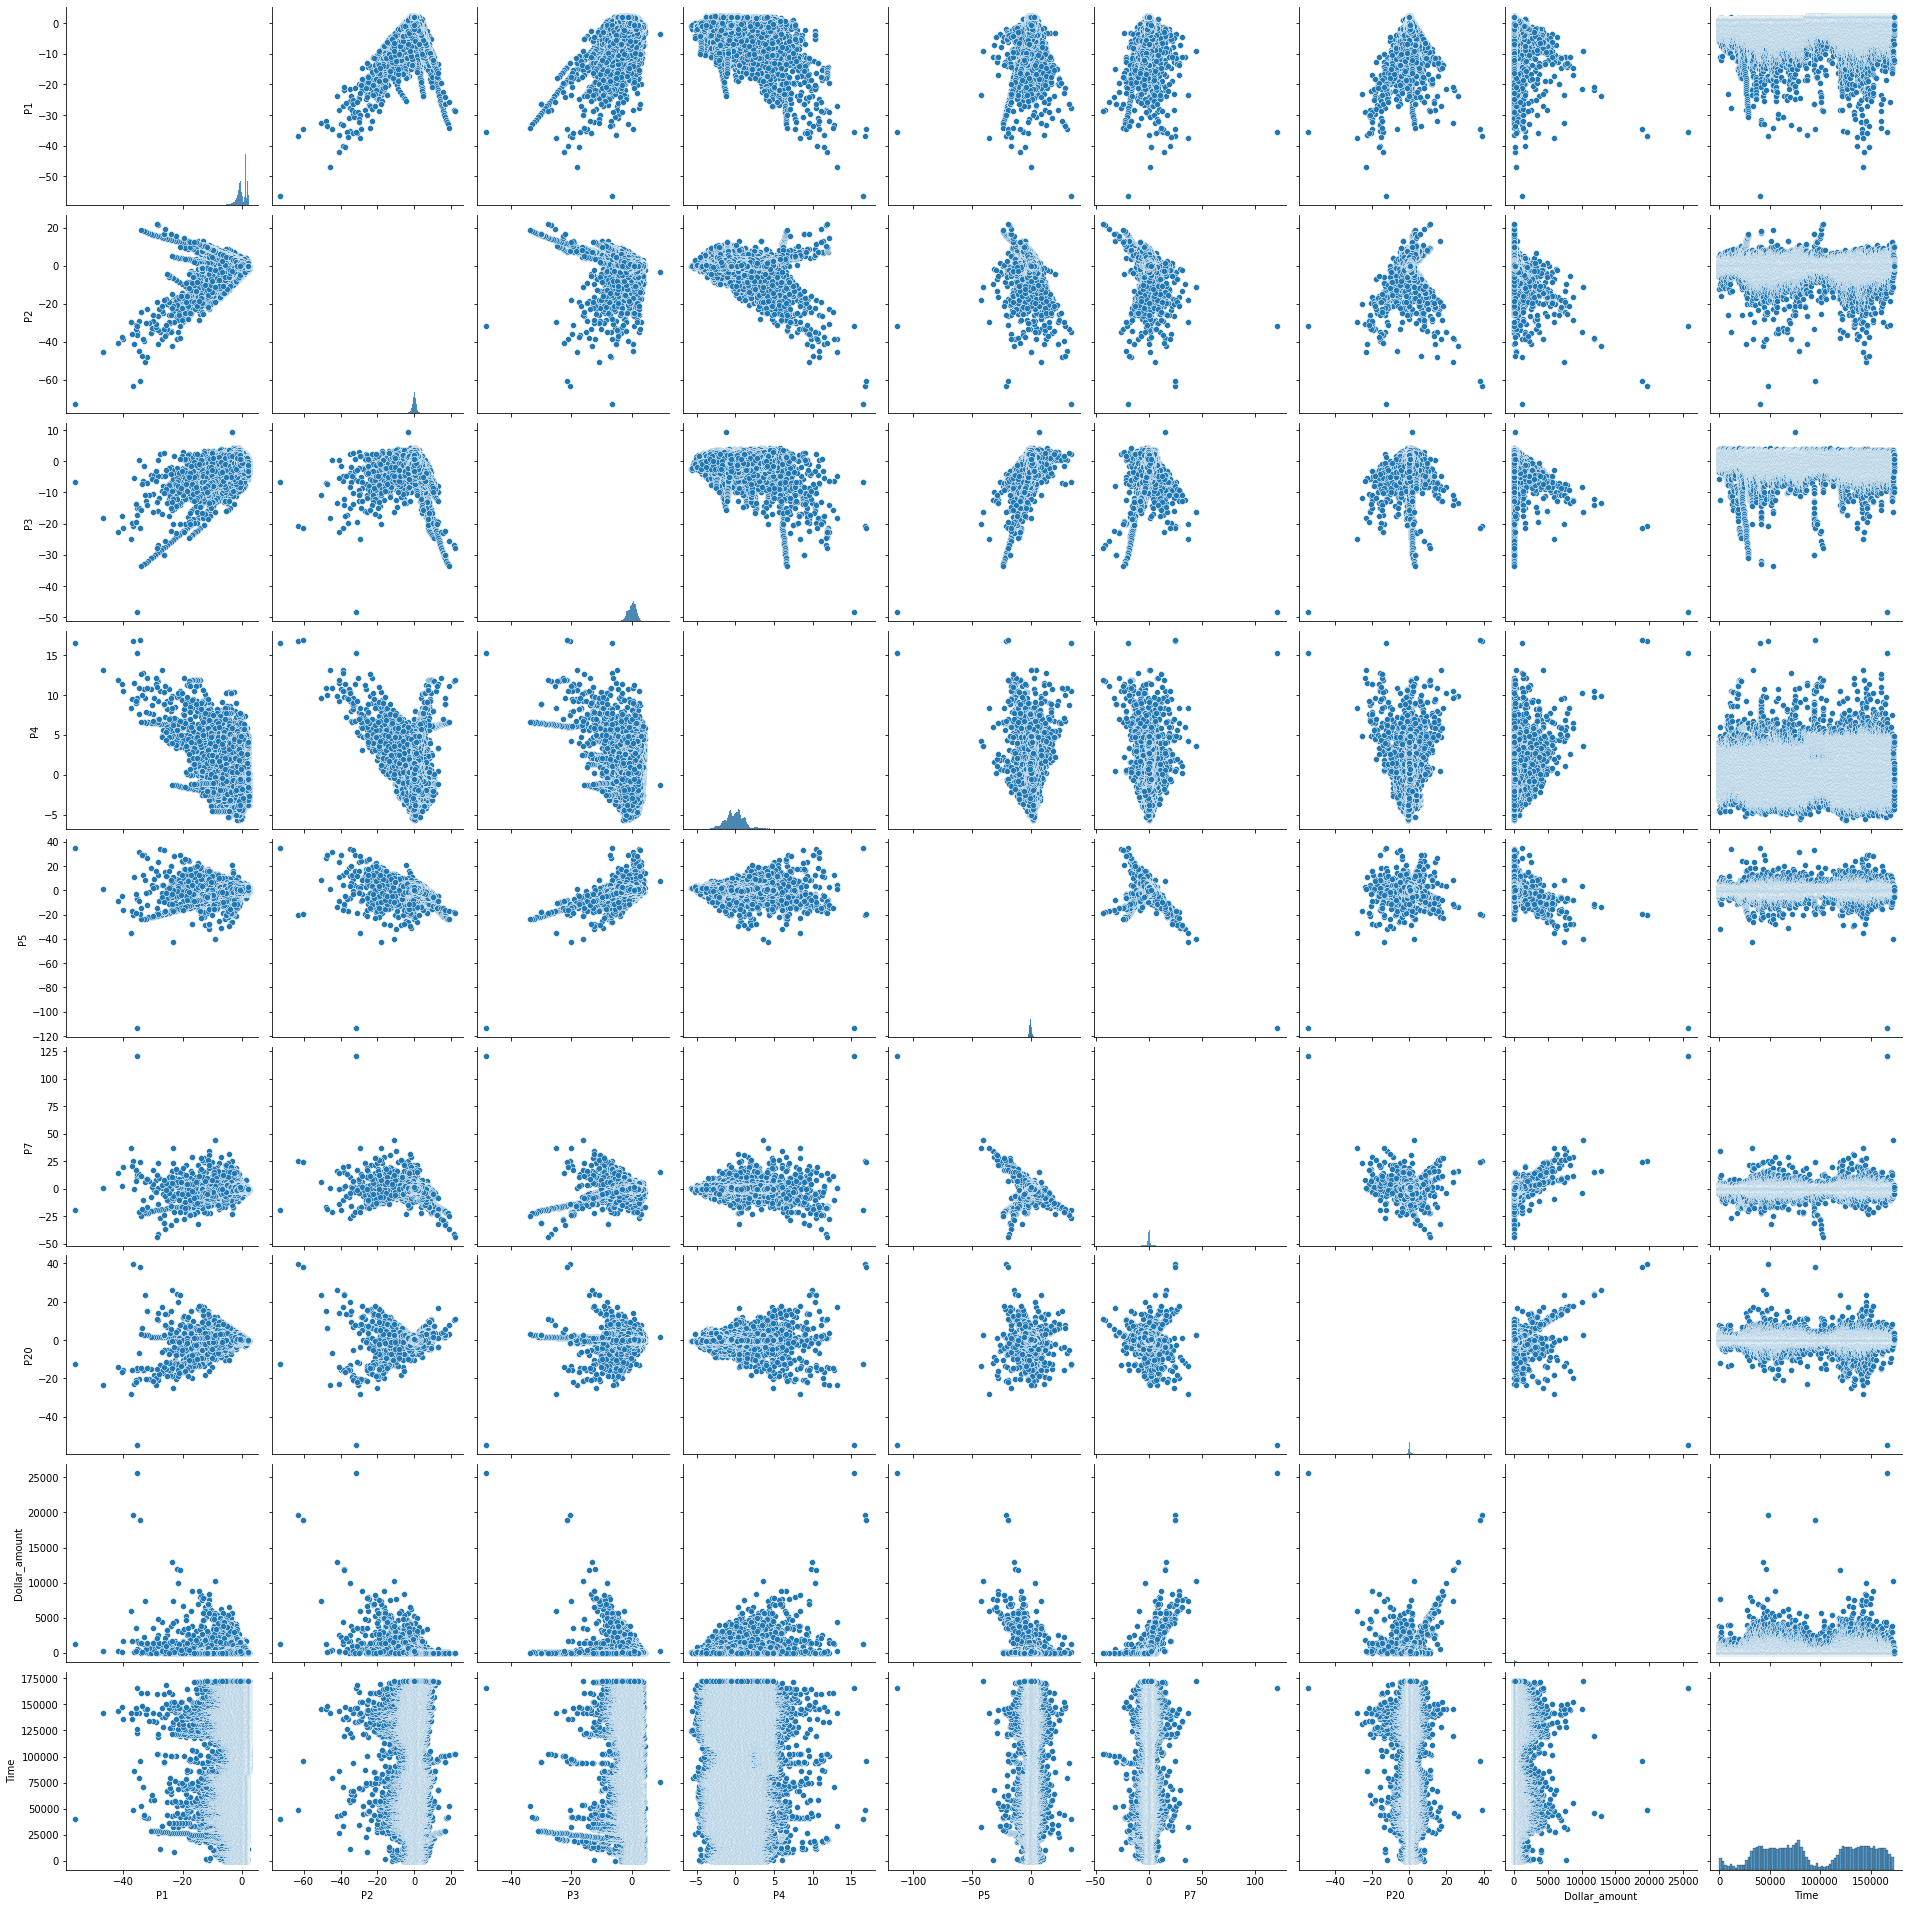

In [10]:
import seaborn as sns
sns.pairplot(
    data=df,
    vars=[
        'P1', 'P2', 'P3', 'P4', 'P5', 'P7', 'P20', 'Dollar_amount', 'Time'
    ],
    height=3,
    aspect=1
)

--- 
# Preparation
## Data and label split

In [11]:
X = df.loc[:, df.columns != 'Outcome']
Y = df.loc[:, ['Outcome']]

In [12]:
Y[~Y['Outcome'].isin([0,1])]

,Outcome


## Train and test split

In [13]:
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, 
    test_size=test_size, 
    random_state=seed,
    stratify=None,
    shuffle=True
)

In [14]:
del df, X, Y

---
# Model Training


## Training on imbalanced

In [15]:
model = XGBClassifier()
model.fit(X_train, y_train)

/home/oonisim/venv/ml/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/oonisim/venv/ml/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/oonisim/venv/ml/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[20:16:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Decision Tree

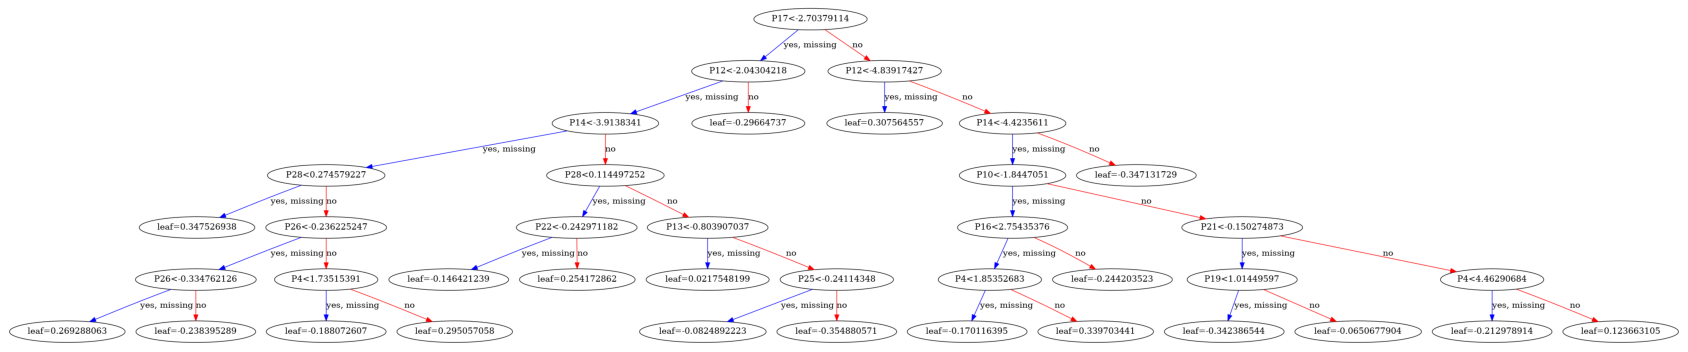

In [16]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model, num_trees=4, ax=ax)
plt.savefig('./image/decision_tree_imbalance.png')
plt.show()

## Performance (imbalanced)

In [17]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

### Recall

In [18]:
recall = recall_score(y_test, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

Recall: 81.00%


### ROC/AUC

In [19]:
auc = roc_auc_score(y_test, predictions)
print("AUC: %.2f%%" % (auc * 100.0))

AUC: 90.50%


In [20]:
del model

---
# Model (SMOTE)

Oversample the data to balance the labels.

In [21]:
from imblearn.over_sampling import (
    SMOTE, 
    ADASYN
)

In [22]:
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)

In [23]:
model_smote = XGBClassifier()
model_smote.fit(X_train_smote, y_train_smote)

/home/oonisim/venv/ml/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/oonisim/venv/ml/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/oonisim/venv/ml/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

[20:17:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Decision Tree

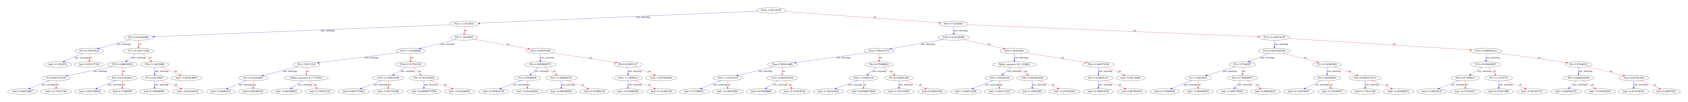

In [24]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model_smote, num_trees=4, ax=ax)
plt.savefig('./image/decision_tree_smote.png')
plt.show()

## Performance (SMOTE)

In [25]:
y_pred_smote = model_smote.predict(X_test)
predictions_smote = [round(value) for value in y_pred_smote]

### Recall

In [26]:
recall = recall_score(y_test, predictions_smote)
print("Recall (SMOTE): %.2f%%" % (recall * 100.0))

Recall (SMOTE): 87.00%


### ROC/AUC

In [27]:
auc = roc_auc_score(y_test, predictions_smote)
print("AUC (SMOTE): %.2f%%" % (auc * 100.0))

AUC (SMOTE): 93.48%


---

# Hyper patameter tuning

Apply Grid Search with Cross Validation to search the hyper parameter space.
* [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

XGBoost has multiple parameters to search for.

* [XGBoost Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)

> Before running XGBoost, we must set three types of parameters: general parameters, booster parameters and task parameters.
>* General parameters relate to which booster we are using to do boosting, commonly tree or linear model
>* Booster parameters depend on which booster you have chosen
>* Learning task parameters decide on the learning scenario. For example, regression tasks may use different parameters with ranking tasks.

In [28]:
parameters = {
    # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 
    'max_depth':[3, 6, 9],
    # The larger min_child_weight is, the more conservative the algorithm will be.
    'min_child_weight':[4, 5, 6],
    # Step size shrinkage used in update to prevents overfitting. 
    'eta': [0.2, 0.3, 0.4],
    #The larger gamma is, the more conservative the algorithm will be.
    'gamma': [0, 0.1, 0.2],
    # Subsample ratio. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. 
    'subsample': [0.1, 0.5, 1.0],
    # L2 regularization term on weights. Increasing this value will make model more conservative.
    'lambda':[0.1, 1, 10],
    #  regularization term on weights. Increasing this value will make model more conservative.
    'alpha': [0, 0.01, 0.05]
}

In [29]:
model_smote = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid=parameters,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    return_train_score=True
)
# model_smote.fit(X_train_smote, y_train_smote)